### Simple ToT

In [7]:
from typing import TypedDict, Annotated, Literal
from operator import add
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate

In [2]:
# state definition
class ToTState(TypedDict):
    problem: str
    approaches: Annotated[list[dict], add] # [{idea: str, reasoning: str, score: int}]
    num_approaches: int
    approaches_generated: Annotated[int, add]
    best_approach: dict
    final_solution: str


In [3]:
llm = ChatOllama(model="llama3.2", temperature=0.8)

In [6]:
generate_approach_prompt = ChatPromptTemplate.from_messages([
    ("human", """problem: {problem}
     
     Generate a unique approach to solve this. Be creative and different from conventional methods.
     Approach {approach_num}: """)
])

In [5]:
# develop the approach
develop_approach_prompt = ChatPromptTemplate.from_messages([
    ("human", """
Problem: {problem}
     
Approach: {approach}

Develop this approach step-by-step. Show your reasoning.
     
Development: 
""")
])

In [7]:
evaluate_approach_prompt = ChatPromptTemplate.from_messages([
    ("human", """Problem: {problem}
     Approach and reasoning: 
     {development}

     Rate this approach from 1-10 based on:
        - Feasibility (can it actually work?)
        - Completeness (does it solve the full problem?)
        - Clarity (is it easy to understand?)

    Respond with ONLY a number from 1-10.
     
    Rating: 
    """)
])

In [8]:
# chains 
generate_chain = generate_approach_prompt | llm
develop_chain = develop_approach_prompt | llm
evaluate_chain = evaluate_approach_prompt | llm

In [25]:
# nodes
def generate_approach(state: ToTState) -> dict:
    """Generate a unique approach to the problem"""
    approach_num = state["approaches_generated"] + 1

    approach_response = generate_chain.invoke({
        "problem": state["problem"],
        "approach_num": approach_num
    })

    approach_idea = approach_response.content.strip()

    # develop the approach
    development_response = develop_chain.invoke({
        "problem": state["problem"],
        "approach": approach_idea
    })

    development = development_response.content.strip()

    # Evaluate the approach
    eval_response = evaluate_chain.invoke({
        "problem": state["problem"],
        "development": development
    })

    try:
        score_text = eval_response.content.strip()
        # import re
        # numbers = re.findall(r'\d+', score_text)
        # if numbers:
        #     score = min(int(numbers[0], 10))
    except:
        pass

    return {
        "approaches": [{
            "idea": approach_idea,
            "reasoning": development,
            "score": score_text
        }],
        "approaches_generated": 1
    }


In [26]:
# node: select the best approach
def select_best(state: ToTState) -> dict:
    """Select the highest scoring approach"""

    if not state["approaches"]:
        return {
            "best_approach": {},
            "final_solution": "No approaches generated"
        }
    
    best = max(state["approaches"], key=lambda x: x["score"])

    return {
        "best_approach": best,
        "final_solution": best["reasoning"]
    }

In [27]:
# routing node
def should_generate_more(state: ToTState) -> str:
    """Decide if we need more approaches"""

    if state["approaches_generated"] >= state["num_approaches"]:
        return "select"
    return "generate"

In [28]:
workflow = StateGraph(ToTState)

workflow.add_node("generate", generate_approach)
workflow.add_node("select", select_best)

workflow.set_entry_point("generate")
workflow.add_conditional_edges(
    "generate",
    should_generate_more,
    {
        "generate": "generate",
        "select": "select"
    }
)
workflow.add_edge("select", END)

tot_agent = workflow.compile()

In [2]:
from IPython.display import Image, display

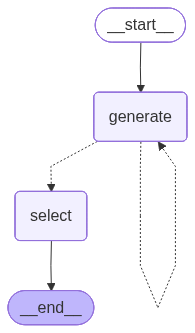

In [30]:
display(Image(tot_agent.get_graph().draw_mermaid_png()))

In [31]:
def solve_with_tot(problem: str, num_approaches: int=3):
    """solve using tree of thoughts"""

    initial_state = {
        "problem": problem,
        "approaches": [],
        "num_approaches": num_approaches,
        "approaches_generated": 0,
        "best_approach": {},
        "final_solution": ""
    }

    print(f"\n{'='*60}")
    print(f"PROBLEM: {problem}")
    print(f"{'='*60}\n")
    print(f"Generating {num_approaches} different approaches...\n")

    result = tot_agent.invoke(initial_state)

    print("ALL APPROACHES:")
    for i, approach in enumerate(result["approaches"], 1):
        print(f"\n--- Approach {i} (Score: {approach['score']}/10) ---")
        print(f"Idea: {approach['idea'][:100]}...")
        print(f"Reasoning: {approach['reasoning'][:150]}...")
    
    print(f"\n{'='*60}")
    print(f"✅ BEST APPROACH (Score: {result['best_approach']['score']}/10)")
    print(f"{'='*60}")
    print(f"\n{result['final_solution']}\n")
    
    return result

In [32]:
solve_with_tot(
        "How can a small business with a limited budget effectively compete with larger companies?",
        num_approaches=3
    )


PROBLEM: How can a small business with a limited budget effectively compete with larger companies?

Generating 3 different approaches...

ALL APPROACHES:

--- Approach 1 (Score: 7/10) ---
Idea: Here's a unique approach to help small businesses with a limited budget compete with larger companie...
Reasoning: **Step 1: Identify a Unique Niche**

To develop a successful "Micro-Specialization" strategy, the first step is to identify a unique niche area within...

--- Approach 2 (Score: 8/10) ---
Idea: Approach 2: "Niche Disruption through Community-Centric Strategy"

In today's competitive market, la...
Reasoning: **Community Engagement**

To develop a community-centric strategy, we'll focus on building strong relationships with key stakeholders in our target co...

--- Approach 3 (Score: 6/10) ---
Idea: Approach 3: "Experience Economy" - Creating Memorable Moments Over Mass Marketing

In today's crowde...
Reasoning: Here's a step-by-step guide to develop an experience economy strategy fo

{'problem': 'How can a small business with a limited budget effectively compete with larger companies?',
 'approaches': [{'idea': 'Here\'s a unique approach to help small businesses with a limited budget compete with larger companies:\n\n**Approach 1: "Micro-Specialization" Strategy**\n\n**Concept:** Focus on becoming a niche expert in a specific area of industry, rather than trying to compete directly with larger companies. This strategy leverages the power of specialization to attract high-quality clients and differentiate the business from larger competitors.\n\n**Key Principles:**\n\n1. **Identify a unique niche**: Analyze your industry and find a specific segment that is underserved or overlooked by larger companies. This could be a specialized service, a specific product offering, or a particular geographic region.\n2. **Develop deep expertise**: Invest time and resources in developing exceptional knowledge and skills within this niche area. This will enable you to provide high-q

### ReAct

In [4]:
from langchain_core.tools import tool

In [5]:
@tool
def search_web(query: str) -> str:
    """Search the web for information."""
    # Simulated search results
    mock_results = {
        "eiffel tower height": "The Eiffel Tower is 330 meters (1,083 feet) tall",
        "python creator": "Python was created by Guido van Rossum in 1991",
        "capital of japan": "Tokyo is the capital of Japan",
    }
    
    query_lower = query.lower()
    for key, value in mock_results.items():
        if key in query_lower:
            return value
    
    return f"Search results for '{query}': No specific information found."

In [6]:
@tool
def calculate(expression: str) -> str:
    """Perform mathematical calculations."""
    try:
        # Safe eval for simple math
        result = eval(expression, {"__builtins__": {}}, {})
        return str(result)
    except Exception as e:
        return f"Calculation error: {str(e)}"

In [7]:
tools = [search_web, calculate]
tool_map = {tool.name: tool for tool in tools}

In [8]:
# state
class ReActState(TypedDict):
    question: str
    thoughts: Annotated[list[str], add]
    actions: Annotated[list[dict], add]  # {action: str, tool: str, input: str}
    observations: Annotated[list[str], add]
    final_answer: str
    step_count: Annotated[int, add]
    max_steps: int
    current_phase: Literal["think", "act", "answer"]

In [9]:
llm = ChatOllama(model="llama3.2", temperature=0.3)

In [10]:
think_prompt = ChatPromptTemplate.from_messages([
    ("human", """You are solving this question: {question}

Previous thoughts and observations:
{history}

Available tools:
- search_web: Search for information online
- calculate: Perform math calculations

Think about what to do next. You can either:
1. Use a tool (specify which tool and what input)
2. Provide the final answer (if you have enough information)

Respond in this format:
Thought: [your reasoning]
Action: [tool_name(input)] OR Final Answer: [your answer]

Your response:""")
])

In [11]:
think_chain = think_prompt | llm

In [12]:
import re

In [45]:
def think(state: ReActState) -> dict:
    """Reasoning phase - decide next action"""
    
    # Build history
    history_parts = []
    for i in range(len(state["thoughts"])):
        history_parts.append(f"Thought {i+1}: {state['thoughts'][i]}")
        if i < len(state["observations"]):
            history_parts.append(f"Observation {i+1}: {state['observations'][i]}")
    
    history = "\n".join(history_parts) if history_parts else "No previous steps."
    
    # Get next thought
    response = think_chain.invoke({
        "question": state["question"],
        "history": history
    })
    
    response_text = response.content.strip()
    
    # Parse response
    thought = ""
    action_line = ""
    
    lines = response_text.split('\n')
    for line in lines:
        if line.startswith("Thought:"):
            thought = line.replace("Thought:", "").strip()
        elif line.startswith("Action:"):
            action_line = line.replace("Action:", "").strip()
        elif line.startswith("Final Answer:"):
            # Ready to answer
            final_answer = line.replace("Final Answer:", "").strip()
            return {
                "thoughts": [thought] if thought else [],
                "final_answer": final_answer,
                "step_count": 1
            }
    
    # Parse action
    if action_line:
        match = re.match(r'(\w+)\((.*)\)', action_line)
        if match:
            tool_name = match.group(1)
            tool_input = match.group(2).strip().strip('"\'')
            
            return {
                "thoughts": [thought] if thought else [],
                "actions": [{
                    "action": action_line,
                    "tool": tool_name,
                    "input": tool_input
                }],
                "step_count": 1
            }
    
    # Fallback: if no clear action, mark as thought only
    return {
        "thoughts": [thought if thought else response_text],
        "step_count": 1
    }

In [46]:
def act(state: ReActState) -> dict:
    """Execute the chosen action (use tool)"""
    
    if not state["actions"]:
        return {
            "observations": ["No action to execute"]
        }
    
    last_action = state["actions"][-1]
    tool_name = last_action["tool"]
    tool_input = last_action["input"]
    
    # Execute tool
    if tool_name in tool_map:
        try:
            result = tool_map[tool_name].invoke(tool_input)
            observation = str(result)
        except Exception as e:
            observation = f"Tool error: {str(e)}"
    else:
        observation = f"Unknown tool: {tool_name}"
    
    return {
        "observations": [observation]
    }

In [47]:
# Routing function - FIXED VERSION
def route_react(state: ReActState) -> str:
    """Route based on current phase and state"""
    
    # Check step limit first
    if state["step_count"] >= state["max_steps"]:
        return "end"
    
    # Check if we have a final answer
    if state["final_answer"]:
        return "end"
    
    # Determine next node based on what we need to do
    # If we have more actions than observations, we need to execute the action
    if len(state["actions"]) > len(state["observations"]):
        return "act"
    
    # Otherwise, we need to think about next step
    return "think"

In [48]:
workflow = StateGraph(ReActState)

workflow.add_node("think", think)
workflow.add_node("act", act)

workflow.set_entry_point("think")

workflow.add_conditional_edges(
    "think",
    route_react,
    {
        "think": "think",
        "act": "act",
        "end": END
    }
)

workflow.add_conditional_edges(
    "act",
    route_react,
    {
        "think": "think",
        "act": "act",  # Added this - in case we need multiple actions
        "end": END
    }
)
react_agent = workflow.compile()

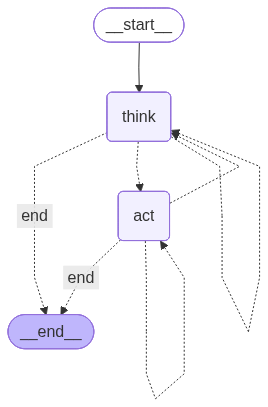

In [49]:
display(Image(react_agent.get_graph().draw_mermaid_png()))

In [50]:
def solve_with_react(question: str, max_steps: int = 5):
    """Solve using ReAct pattern"""
    
    initial_state = {
        "question": question,
        "thoughts": [],
        "actions": [],
        "observations": [],
        "final_answer": "",
        "step_count": 0,
        "max_steps": max_steps,
        "current_phase": "think"
    }
    
    print(f"\n{'='*60}")
    print(f"QUESTION: {question}")
    print(f"{'='*60}\n")
    
    result = react_agent.invoke(initial_state)
    
    # Display trace
    print("REACT TRACE:")
    for i in range(len(result["thoughts"])):
        print(f"\n💭 Thought {i+1}: {result['thoughts'][i]}")
        
        if i < len(result["actions"]):
            action = result["actions"][i]
            print(f"🔧 Action {i+1}: {action['action']}")
        
        if i < len(result["observations"]):
            print(f"👁️ Observation {i+1}: {result['observations'][i]}")
    
    print(f"\n{'='*60}")
    print(f"✅ FINAL ANSWER:")
    print(f"{result['final_answer']}")
    print(f"{'='*60}\n")
    
    return result

In [51]:
solve_with_react(
        "How tall is the Eiffel Tower and what is half of that height in meters?"
    )


QUESTION: How tall is the Eiffel Tower and what is half of that height in meters?

REACT TRACE:

💭 Thought 1: To find the height of the Eiffel Tower, I should search for its official height to get accurate information.
🔧 Action 1: search_web("Eiffel Tower height in meters")
👁️ Observation 1: The Eiffel Tower is 330 meters (1,083 feet) tall

💭 Thought 2: Since I already have the official height of the Eiffel Tower as 330 meters, I can directly calculate half of that height without needing to search for additional information.
🔧 Action 2: calculate(330 / 2)
👁️ Observation 2: 165.0

💭 Thought 3: Since I already have the official height of the Eiffel Tower as 330 meters, I can directly calculate half of that height without needing to search for additional information.
🔧 Action 3: calculate(330 / 2)
👁️ Observation 3: 165.0

💭 Thought 4: Since I already have the official height of the Eiffel Tower as 330 meters, and I've confirmed that half of that height is indeed 165.0 meters through my o

{'question': 'How tall is the Eiffel Tower and what is half of that height in meters?',
 'thoughts': ['To find the height of the Eiffel Tower, I should search for its official height to get accurate information.',
  'Since I already have the official height of the Eiffel Tower as 330 meters, I can directly calculate half of that height without needing to search for additional information.',
  'Since I already have the official height of the Eiffel Tower as 330 meters, I can directly calculate half of that height without needing to search for additional information.',
  "Since I already have the official height of the Eiffel Tower as 330 meters, and I've confirmed that half of that height is indeed 165.0 meters through my observations, there's no need to search for additional information or perform further calculations.",
  "I've already confirmed that half of the Eiffel Tower's height is 165.0 meters through my observations and calculations, so there's no need to perform further action

In [52]:
solve_with_react(
        "What is 15% of 240, and then add 30 to that result?"
    )


QUESTION: What is 15% of 240, and then add 30 to that result?

REACT TRACE:

💭 Thought 1: To find 15% of 240, I need to calculate 15% of the number 240.
🔧 Action 1: calculate(240 * 0.15)
👁️ Observation 1: 36.0

💭 Thought 2: To find 15% of 240, I can use the calculate tool to multiply 240 by 0.15.
🔧 Action 2: calculate(240 * 0.15)
👁️ Observation 2: 36.0

💭 Thought 3: Since I already calculated 15% of 240 as 36.0, and now I need to add 30 to that result, I can simply perform the addition.
🔧 Action 3: calculate(36.0 + 30)
👁️ Observation 3: 66.0

💭 Thought 4: Since I already calculated 15% of 240 as 36.0, and now I need to add 30 to that result, I can simply perform the addition.
🔧 Action 4: calculate(36.0 + 30)
👁️ Observation 4: 66.0

💭 Thought 5: Since I already calculated 15% of 240 as 36.0, and now I need to add 30 to that result, I can simply perform the addition.
🔧 Action 5: calculate(36.0 + 30)

✅ FINAL ANSWER:




{'question': 'What is 15% of 240, and then add 30 to that result?',
 'thoughts': ['To find 15% of 240, I need to calculate 15% of the number 240.',
  'To find 15% of 240, I can use the calculate tool to multiply 240 by 0.15.',
  'Since I already calculated 15% of 240 as 36.0, and now I need to add 30 to that result, I can simply perform the addition.',
  'Since I already calculated 15% of 240 as 36.0, and now I need to add 30 to that result, I can simply perform the addition.',
  'Since I already calculated 15% of 240 as 36.0, and now I need to add 30 to that result, I can simply perform the addition.'],
 'actions': [{'action': 'calculate(240 * 0.15)',
   'tool': 'calculate',
   'input': '240 * 0.15'},
  {'action': 'calculate(240 * 0.15)',
   'tool': 'calculate',
   'input': '240 * 0.15'},
  {'action': 'calculate(36.0 + 30)',
   'tool': 'calculate',
   'input': '36.0 + 30'},
  {'action': 'calculate(36.0 + 30)',
   'tool': 'calculate',
   'input': '36.0 + 30'},
  {'action': 'calculate(3

### Plan and Execute

In [6]:
import re

In [8]:
# State definition
class PlanExecuteState(TypedDict):
    task: str
    plan: list[str]  # List of steps
    plan_created: bool
    current_step_idx: int
    step_results: Annotated[list[dict], add]  # [{step: str, result: str}]
    final_summary: str
    status: Literal["planning", "executing", "reviewing", "complete"]

# Initialize
llm = ChatOllama(model="llama3.2", temperature=0.3)

# Prompt: Create plan
plan_prompt = ChatPromptTemplate.from_messages([
    ("human", """Task: {task}

Create a step-by-step plan to accomplish this task. Each step should be clear and actionable.

Provide your plan as a numbered list:
1. [First step]
2. [Second step]
...

Plan:""")
])

# Prompt: Execute step
execute_prompt = ChatPromptTemplate.from_messages([
    ("human", """Overall task: {task}

Full plan:
{full_plan}

Current step: {current_step}

Execute this step and provide the result.

Result:""")
])

# Prompt: Review
review_prompt = ChatPromptTemplate.from_messages([
    ("human", """Task: {task}

Plan executed:
{plan_with_results}

Provide a brief summary of what was accomplished.

Summary:""")
])

# Chains
plan_chain = plan_prompt | llm
execute_chain = execute_prompt | llm
review_chain = review_prompt | llm

# Node: Create plan
def create_plan(state: PlanExecuteState) -> dict:
    """Create execution plan"""
    
    response = plan_chain.invoke({"task": state["task"]})
    
    # Parse plan (extract numbered items)
    plan_text = response.content
    steps = []
    
    for line in plan_text.split('\n'):
        line = line.strip()
        # Match "1. Step", "1) Step", or "Step 1: ..."
        if line and (line[0].isdigit() or line.startswith('Step')):
            # Clean up the step
            step = re.sub(r'^\d+[\.\)]\s*', '', line)
            step = re.sub(r'^Step\s+\d+:\s*', '', step)
            if step:
                steps.append(step)
    
    if not steps:
        # Fallback: treat whole response as one step
        steps = [plan_text.strip()]
    
    return {
        "plan": steps,
        "plan_created": True,
        "status": "executing"
    }

# Node: Execute step
def execute_step(state: PlanExecuteState) -> dict:
    """Execute current step in plan"""
    
    if state["current_step_idx"] >= len(state["plan"]):
        return {"status": "reviewing"}
    
    current_step = state["plan"][state["current_step_idx"]]
    
    # Format full plan for context
    full_plan = "\n".join([
        f"{i+1}. {step}" 
        for i, step in enumerate(state["plan"])
    ])
    
    # Execute step
    response = execute_chain.invoke({
        "task": state["task"],
        "full_plan": full_plan,
        "current_step": current_step
    })
    
    result = response.content.strip()
    
    # Record result
    step_result = {
        "step": current_step,
        "result": result
    }
    
    # Move to next step
    next_idx = state["current_step_idx"] + 1
    next_status = "executing" if next_idx < len(state["plan"]) else "reviewing"
    
    return {
        "step_results": [step_result],
        "current_step_idx": next_idx,
        "status": next_status
    }

# Node: Review results
def review_results(state: PlanExecuteState) -> dict:
    """Review all execution results"""
    
    # Format plan with results
    plan_with_results = []
    for i, step_result in enumerate(state["step_results"], 1):
        plan_with_results.append(
            f"Step {i}: {step_result['step']}\nResult: {step_result['result']}"
        )
    
    combined = "\n\n".join(plan_with_results)
    
    # Generate summary
    response = review_chain.invoke({
        "task": state["task"],
        "plan_with_results": combined
    })
    
    return {
        "final_summary": response.content.strip(),
        "status": "complete"
    }

# Routing
def route_plan_execute(state: PlanExecuteState) -> str:
    """Route based on status"""
    
    status = state["status"]
    
    if status == "planning":
        return "plan"
    elif status == "executing":
        return "execute"
    elif status == "reviewing":
        return "review"
    elif status == "complete":
        return "end"
    
    return "end"

# Build graph
workflow = StateGraph(PlanExecuteState)

workflow.add_node("plan", create_plan)
workflow.add_node("execute", execute_step)
workflow.add_node("review", review_results)

workflow.set_entry_point("plan")

# Add routing from each node
workflow.add_conditional_edges(
    "plan",
    route_plan_execute,
    {
        "execute": "execute",
        "end": END
    }
)

workflow.add_conditional_edges(
    "execute",
    route_plan_execute,
    {
        "execute": "execute",
        "review": "review",
        "end": END
    }
)

workflow.add_conditional_edges(
    "review",
    route_plan_execute,
    {
        "end": END
    }
)

# Compile
plan_execute_agent = workflow.compile()

# Test function
def solve_with_plan_execute(task: str):
    """Solve using Plan-and-Execute pattern"""
    
    initial_state = {
        "task": task,
        "plan": [],
        "plan_created": False,
        "current_step_idx": 0,
        "step_results": [],
        "final_summary": "",
        "status": "planning"
    }
    
    print(f"\n{'='*60}")
    print(f"TASK: {task}")
    print(f"{'='*60}\n")
    
    result = plan_execute_agent.invoke(initial_state)
    
    # Display plan
    print("📋 PLAN:")
    for i, step in enumerate(result["plan"], 1):
        print(f"  {i}. {step}")
    
    # Display execution
    print(f"\n⚙️ EXECUTION:")
    for i, step_result in enumerate(result["step_results"], 1):
        print(f"\n  Step {i}: {step_result['step']}")
        print(f"  Result: {step_result['result'][:100]}...")
    
    # Display summary
    print(f"\n{'='*60}")
    print(f"✅ SUMMARY:")
    print(f"{result['final_summary']}")
    print(f"{'='*60}\n")
    
    return result

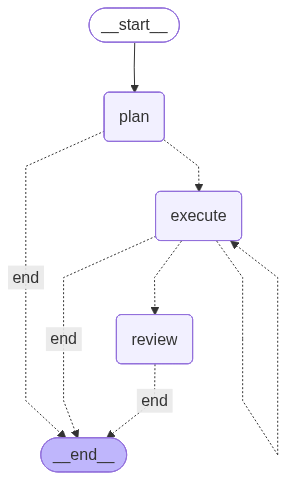

In [9]:
display(Image(plan_execute_agent.get_graph().draw_mermaid_png()))

In [10]:
solve_with_plan_execute(
        "Research the history of artificial intelligence and create a timeline of major milestones"
    )


TASK: Research the history of artificial intelligence and create a timeline of major milestones

📋 PLAN:
  1. **Define the scope and focus**: Determine what aspects of AI history you want to cover, such as the development of machine learning, natural language processing, or robotics. Decide on a time period, e.g., 1950s-2020s.
  2. **Gather primary sources**: Identify key books, articles, and research papers that have contributed significantly to the development of AI. Some notable works include:
  3. **Conduct online research**: Utilize online archives, libraries, and databases to gather information on AI milestones. Some relevant resources include:
  4. **Consult AI history books and documentaries**: Read books that provide an overview of AI's development, such as:
  5. **Create a timeline framework**: Organize your research into a chronological framework, including key events, dates, and milestones.
  6. **Identify major AI milestones**: Based on your research, identify significant

{'task': 'Research the history of artificial intelligence and create a timeline of major milestones',
 'plan': ['**Define the scope and focus**: Determine what aspects of AI history you want to cover, such as the development of machine learning, natural language processing, or robotics. Decide on a time period, e.g., 1950s-2020s.',
  '**Gather primary sources**: Identify key books, articles, and research papers that have contributed significantly to the development of AI. Some notable works include:',
  '**Conduct online research**: Utilize online archives, libraries, and databases to gather information on AI milestones. Some relevant resources include:',
  "**Consult AI history books and documentaries**: Read books that provide an overview of AI's development, such as:",
  '**Create a timeline framework**: Organize your research into a chronological framework, including key events, dates, and milestones.',
  '**Identify major AI milestones**: Based on your research, identify significa